# SynFerm Exploratory Data Analysis
#### Targets:
- See some of the basic trends in the data (which BBs react well? which not at all?)
- perform basic statistics (How many successful reactions?)

#### Sections:
1. [Load and filter data](#1)
2. [Investigate "invalid" reactions](#2)
3. [General Statistics](#3)
4. [Building Block Statistics](#4)
5. [Trends within builing block classes](#5)
6. [Trends within builing block classes, corrected for monomers performance](#6)

In [33]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
from definitions import DB_PATH
from src.db_retrieval.db_queries import MyDatabaseConnection

### Load and filter data <a id='section_id'></a>

In [34]:
import sqlite3
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 100  # this makes the figures bigger in jupyter nb

In [35]:
db = MyDatabaseConnection()  # we will use this for various simple queries

In [36]:
con = sqlite3.connect(DB_PATH)
df_full = pd.read_sql('SELECT * FROM experiments', con, index_col='id', coerce_float=False ,parse_dates={'synthesis_date_unixepoch': {'utc': False, 'unit': 's'}})
con.close()
print(f'Number of reactions (in total): {len(df_full)}')

Number of reactions (in total): 21544


In [37]:
df_full = df_full.loc[df_full['exp_nr'].between(4, 100)]  # kick out invalid experiments (SOP changed after exp3)
print(f'Number of reactions since SOP change and without test reactions: {len(df_full)}')

Number of reactions since SOP change and without test reactions: 13440


### Investigate "invalid" reactions <a id=2></a>

In [38]:
# how many reactions might be invalid?
df_full.loc[:,'valid'].value_counts().head(10)

heating failure                                                                  1920
too many peaks for product A (2)                                                  525
too many peaks for product A (3)                                                  237
ERROR: I/M transfer error                                                         173
bad LCMS M61                                                                      142
I/M transfer error; Dilution survey low volume                                    130
ERROR: too many peaks for IS (2); WARNING: IS response differs >50% from mean     128
too many peaks for IS (2); WARNING: IS response differs >50% from mean            113
Name: valid, dtype: int64

In [39]:
# let's see these invalid reactions
df_full.loc[df_full['valid'] == 'too many peaks for product A (4)']

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,product_A_smiles,product_B_smiles,product_C_smiles,product_D_smiles,product_E_smiles,product_F_smiles,product_G_smiles,product_H_smiles,vl_id,valid
id,,,,,,,,,,,,,,,,,,,,,
11548,4,2,A13,JG247,2021-07-14 22:00:00,I15,M63,T28,4-Pym001,Spiro005,...,COc1cc(C(=O)NCC2(c3nnc(-c4ccc(C(F)(F)F)cc4)s3)...,COc1cc(C(=O)NCC2(C3(C(=O)O)NN=C(c4ccc(C(F)(F)F...,COc1cc(C2=[N+]3N=C(c4ccc(C(F)(F)F)cc4)SC3(C(=O...,COc1cc(-c2nnc(-c3ccc(C(F)(F)F)cc3)s2)ncn1,FC(F)(F)c1ccc(-c2nnc(-c3ccc(C(F)(F)F)cc3)s2)cc1,COc1cc(C(=O)NCC2(C(=O)C(=O)O)CCOCC2)ncn1,COc1cc(C(=O)NCC2(C(=O)O)CCOCC2)ncn1,None,45046,too many peaks for product A (4)
11654,4,2,F19,JG247,2021-07-14 22:00:00,I18,M63,T3,4-Pyrazole002,Spiro005,...,Cc1ccc2nc(C3(CNC(=O)n4nccc4C(=O)OC(C)(C)C)CCOC...,Cc1ccc2c(c1)SC(C(=O)O)(C1(CNC(=O)n3nccc3C(=O)O...,Cc1ccc2c(c1)SC1(C(=O)[O-])[N+]2=C(n2nccc2C(=O)...,Cc1ccc2nc(-n3nccc3C(=O)OC(C)(C)C)sc2c1,Cc1ccc(N)c(SSc2cc(C)ccc2N)c1,CC(C)(C)OC(=O)c1ccnn1C(=O)NCC1(C(=O)C(=O)O)CCOCC1,CC(C)(C)OC(=O)c1ccnn1C(=O)NCC1(C(=O)O)CCOCC1,O,54123,too many peaks for product A (4)
12631,4,4,G16,JG249,2021-07-14 22:00:00,I14,M68,T40,3-Thio001,Spiro011,...,O=C(NC1(Cc2nnc(-c3ccc4[nH]nnc4c3)s2)CCSC1)c1ccsc1,O=C(NC1(CC2(C(=O)O)NN=C(c3ccc4[nH]nnc4c3)S2)CC...,O=C([O-])C12CC3(CCSC3)NC(c3ccsc3)=[N+]1N=C(c1c...,c1cc(-c2nnc(-c3ccc4[nH]nnc4c3)s2)cs1,c1cc2[nH]nnc2cc1-c1nnc(-c2ccc3[nH]nnc3c2)s1,O=C(O)C(=O)CC1(NC(=O)c2ccsc2)CCSC1,O=C(O)CC1(NC(=O)c2ccsc2)CCSC1,C(=C1CCSC1)c1nnc(-c2ccc3[nH]nnc3c2)s1,42229,too many peaks for product A (4)
12632,4,4,G17,JG249,2021-07-14 22:00:00,I14,M68,T20,3-Thio001,Spiro011,...,O=C(NC1(Cc2nnc(-c3cccs3)s2)CCSC1)c1ccsc1,O=C(NC1(CC2(C(=O)O)NN=C(c3cccs3)S2)CCSC1)c1ccsc1,O=C([O-])C12CC3(CCSC3)NC(c3ccsc3)=[N+]1N=C(c1c...,c1csc(-c2nnc(-c3ccsc3)s2)c1,c1csc(-c2nnc(-c3cccs3)s2)c1,O=C(O)C(=O)CC1(NC(=O)c2ccsc2)CCSC1,O=C(O)CC1(NC(=O)c2ccsc2)CCSC1,C(=C1CCSC1)c1nnc(-c2cccs2)s1,42209,too many peaks for product A (4)
12649,4,4,H14,JG249,2021-07-14 22:00:00,I70,M68,T32,Ph026,Spiro011,...,CCOC(=O)c1cccc(C(=O)NC2(Cc3nnc(-c4ccccc4Cl)s3)...,CCOC(=O)c1cccc(C(=O)NC2(CC3(C(=O)O)NN=C(c4cccc...,CCOC(=O)c1cccc(C2=[N+]3N=C(c4ccccc4Cl)SC3(C(=O...,CCOC(=O)c1cccc(-c2nnc(-c3ccccc3Cl)s2)c1,Clc1ccccc1-c1nnc(-c2ccccc2Cl)s1,CCOC(=O)c1cccc(C(=O)NC2(CC(=O)C(=O)O)CCSC2)c1,CCOC(=O)c1cccc(C(=O)NC2(CC(=O)O)CCSC2)c1,Clc1ccccc1-c1nnc(C=C2CCSC2)s1,212125,too many peaks for product A (4)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16960,7,5,P5,JG268,2021-09-15 22:00:00,I33,M4,T30,Al038,Fused011,...,CC(C(=O)N[C@H]1COc2ccccc2[C@@H]1c1nnc(-c2cc(Cl...,CC(C(=O)N[C@H]1COc2ccccc2[C@@H]1C1(C(=O)O)NN=C...,CC(C1=[N+]2N=C(c3cc(Cl)cc(Cl)c3)SC2(C(=O)[O-])...,CC(c1ccccc1)c1nnc(-c2cc(Cl)cc(Cl)c2)s1,Clc1cc(Cl)cc(-c2nnc(-c3cc(Cl)cc(Cl)c3)s2)c1,CC(C(=O)N[C@H]1COc2ccccc2[C@@H]1C(=O)C(=O)O)c1...,CC(C(=O)N[C@H]1COc2ccccc2[C@@H]1C(=O)O)c1ccccc1,Clc1cc(Cl)cc(-c2nnc(C3=CCOc4ccccc43)s2)c1,97241,too many peaks for product A (4)
16967,7,5,P12,JG268,2021-09-15 22:00:00,I33,M4,T22,Al038,Fused011,...,COc1ccc(-c2nnc([C@H]3c4ccccc4OC[C@@H]3NC(=O)C(...,COc1ccc(C2=NNC(C(=O)O)([C@H]3c4ccccc4OC[C@@H]3...,COc1ccc(C2=N[N+]3=C(C(C)c4ccccc4)N[C@H]4COc5cc...,COc1ccc(-c2nnc(C(C)c3ccccc3)s2)cc1,COc1ccc(-c2nnc(-c3ccc(OC)cc3)s2)cc1,CC(C(=O)N[C@H]1COc2ccccc2[C@@H]1C(=O)C(=O)O)c1...,CC(C(=O)N[C@H]1COc2ccccc2[C@@H]1C(=O)O)c1ccccc1,COc1ccc(-c2nnc(C3=CCOc4ccccc43)s2)cc1,97233,too many peaks for product A (4)
16969,7,5,P14,JG268,2021-09-15 22:00:00,I33,M54,T39,Al038,Mon100,...,CC(C(=O)NC[C@@H](c1cccnc1)c1nnc(-c2cn[nH]c2)s1...,CC(C(=O)NC[C@@H](c1cccnc1)C1(C(=O)O)NN=C(c2cn[...,CC(C1=[N+]2N=C(c3cn[nH]c3)SC2(C(=O)[O-])[C@H](...,CC(c1ccccc1)c1nnc(-c2cn[nH]c2)s1,c1n[nH]cc1-c1nnc(-c2cn[nH]c2)s1,CC(C(=O)NC[C@H](C(=O)C(=O)O)c1cccnc1)c1ccccc1,CC(C(=O)NC[C@H](C(=O)O)c1cccnc1)c1ccccc1,C=C(c1cccnc1)c1nnc(-c2cn[nH]c2)s1,99300,too many peaks for product A (4)


Let's have a look at the worst offenders. there might be a structural reason why they give multiple peaks in LCMS

In [40]:
x = df_full.loc[df_full['valid'] == 'too many peaks for product A (2)', ['initiator']].value_counts()
x

initiator
I65          27
I4           26
I6           26
I29          25
I40          25
I14          24
I15          23
I3           23
I77          22
I22          22
I70          21
I7           21
I32          21
I64          19
I50          19
I10          18
I71          17
I5           16
I28          16
I72          16
I17          15
I12          14
I47          12
I30          12
I60           9
I25           9
I23           8
I33           7
I44           6
I36           5
I18           1
dtype: int64

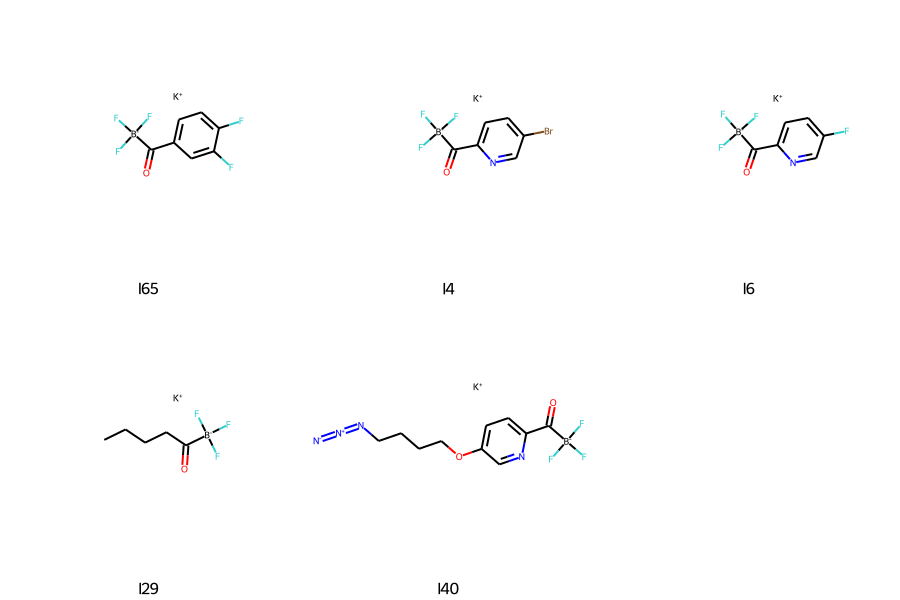

In [41]:
# let's look at these molecules
mols = []
for bb in x.head(5).index.to_list():
    mols.append(db.get_mol(short=bb[0]))
from rdkit.Chem import Draw
Draw.MolsToGridImage(mols, subImgSize=(300,300), legends=[bb[0] for bb in x.index.to_list()])

In [42]:
x = df_full.loc[df_full['valid'] == 'too many peaks for product A (4)', ['monomer']].value_counts()
x

monomer
M4         22
M54        16
M68        14
M67         5
M43         4
M63         4
M66         3
M73         3
M29         2
M3          2
M15         1
M32         1
M58         1
M72         1
dtype: int64

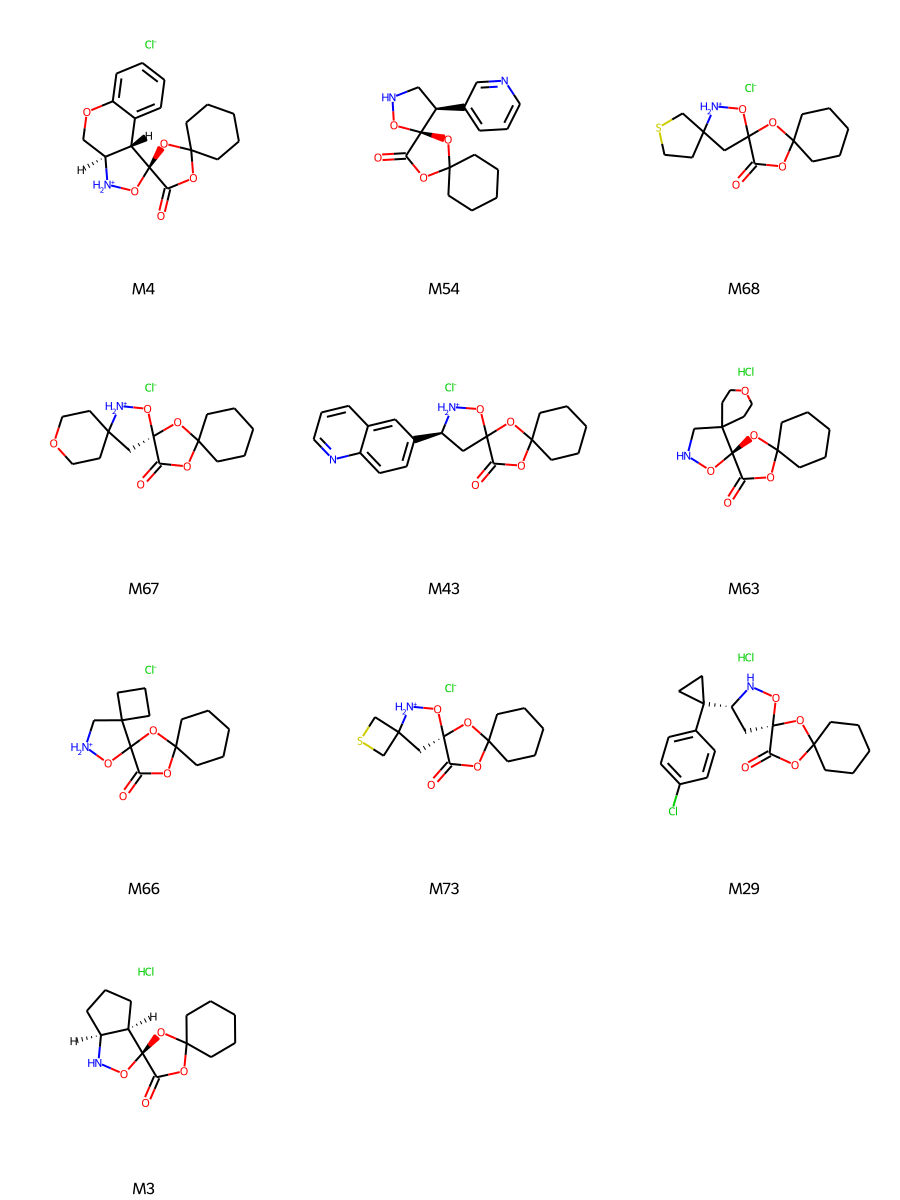

In [43]:
# let's look at these molecules
mols = []
for bb in x.head(10).index.to_list():
    mols.append(db.get_mol(short=bb[0]))
from rdkit.Chem import Draw
Draw.MolsToGridImage(mols, subImgSize=(300,300), legends=[bb[0] for bb in x.index.to_list()])

In [44]:
x = df_full.loc[df_full['valid'] == 'too many peaks for product A (4)', ['terminator']].value_counts()
x

terminator
T20           8
T21           8
T28           8
T1            7
T40           7
T22           6
T30           6
T36           6
T34           4
T39           4
T3            3
T32           3
T7            3
T13           2
T17           2
T31           2
dtype: int64

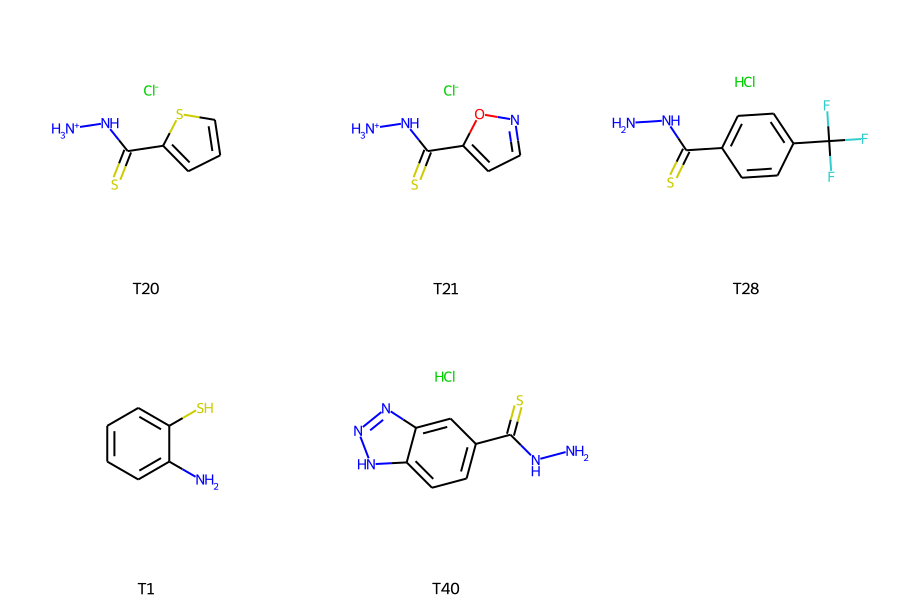

In [45]:
# let's look at these molecules
mols = []
for bb in x.head(5).index.to_list():
    mols.append(db.get_mol(short=bb[0]))
from rdkit.Chem import Draw
Draw.MolsToGridImage(mols, subImgSize=(300,300), legends=[bb[0] for bb in x.index.to_list()])

#### Remove invalid reactions
It seems reasonable to assume that up to 4 peaks for A could be from diasteromers + regioisomers so we will accept anything that has 4 or less peaks for A into our cleaned data set

In [46]:
df = df_full.loc[df_full['valid'].isna() 
                 | (df_full['valid'] == 'heating failure') 
                 | (df_full['valid'] == 'too many peaks for product A (2)') 
                 | (df_full['valid'] == 'too many peaks for product A (3)')
                 | (df_full['valid'] == 'too many peaks for product A (4)')
                ] 
print(f'Number of reactions after removing invalid entries: {len(df)}')

Number of reactions after removing invalid entries: 10913


In [47]:
df = df.loc[~df['product_A_lcms_ratio'].isna()]  # remove all entries where product A is NaN (these are the entries not yet measured)
print(f'Number of reactions after removing NaN entries: {len(df)}')

Number of reactions after removing NaN entries: 10913


Now we have a cleaned dataset. Let's try some basic statistics

How many reactions are successful (i.e. normalized lmcs ratio for A > 5% ?)

In [48]:
# first normalize all the lcms columns seperately
from copy import deepcopy
df = deepcopy(df)
lcms_df = df[['product_A_lcms_ratio', 'product_B_lcms_ratio', 'product_C_lcms_ratio', 'product_D_lcms_ratio', 'product_E_lcms_ratio', 'product_F_lcms_ratio', 'product_G_lcms_ratio', 'product_H_lcms_ratio']]
# df['A_normalized'] = (df['product_A_lcms_ratio']-df['product_A_lcms_ratio'].min())/(df['product_A_lcms_ratio'].max()-df['product_A_lcms_ratio'].min())
df[['A_normalized','B_normalized', 'C_normalized', 'D_normalized', 'E_normalized', 'F_normalized', 'G_normalized', 'H_normalized']] = (lcms_df-lcms_df.min())/(lcms_df.max()-lcms_df.min())
df                                      

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,vl_id,valid,A_normalized,B_normalized,C_normalized,D_normalized,E_normalized,F_normalized,G_normalized,H_normalized
id,,,,,,,,,,,,,,,,,,,,,
9618,5,2,A3,JG253,2021-08-16 22:00:00,I67,M2,T25,Ph023,Fused005,...,200310,heating failure,0.000227,0.0,0.000335,0.000000,0.013379,0.000000,0.000000,0.000000
9619,5,2,A4,JG253,2021-08-16 22:00:00,I67,M2,T39,Ph023,Fused005,...,200324,heating failure,0.000000,0.0,0.000000,0.000000,0.001412,0.000000,0.000041,0.000000
9620,5,2,A5,JG253,2021-08-16 22:00:00,I67,M2,T30,Ph023,Fused005,...,200315,heating failure,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9621,5,2,A6,JG253,2021-08-16 22:00:00,I67,M2,T34,Ph023,Fused005,...,200319,heating failure,0.000000,0.0,0.000000,0.000095,0.006787,0.000000,0.000000,0.000000
9622,5,2,A7,JG253,2021-08-16 22:00:00,I67,M2,T17,Ph023,Fused005,...,200302,heating failure,0.000429,0.0,0.000000,0.000252,0.000662,0.000000,0.000000,0.000641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25356,10,6,P4,JG288,2021-11-15 23:00:00,I57,M67,T11,Ph007,Spiro009,...,172621,None,0.000000,0.0,0.000000,0.324803,0.068527,0.000033,0.000000,0.093324
25357,10,6,P5,JG288,2021-11-15 23:00:00,I57,M67,T26,Ph007,Spiro009,...,172636,None,0.000391,0.0,0.000000,0.074256,0.076158,0.000000,0.000000,0.002204
25358,10,6,P6,JG288,2021-11-15 23:00:00,I57,M67,T29,Ph007,Spiro009,...,172639,None,0.000000,0.0,0.000000,0.027921,0.002130,0.000000,0.000000,0.000000


In [49]:
# add information about reactant classes to df
def get_reaction_type_for_series(ser):
    new = []
    for i in ser:
        new.append(db.get_reactant_class(i))
    return pd.Series(data=new)
        
df[['initiator_type', 'monomer_type', 'terminator_type']] = df[['initiator', 'monomer', 'terminator']].apply(get_reaction_type_for_series, axis=1)
df

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,B_normalized,C_normalized,D_normalized,E_normalized,F_normalized,G_normalized,H_normalized,initiator_type,monomer_type,terminator_type
id,,,,,,,,,,,,,,,,,,,,,
9618,5,2,A3,JG253,2021-08-16 22:00:00,I67,M2,T25,Ph023,Fused005,...,0.0,0.000335,0.000000,0.013379,0.000000,0.000000,0.000000,KAT_arom,Mon_fused,TerTH
9619,5,2,A4,JG253,2021-08-16 22:00:00,I67,M2,T39,Ph023,Fused005,...,0.0,0.000000,0.000000,0.001412,0.000000,0.000041,0.000000,KAT_arom,Mon_fused,TerTH
9620,5,2,A5,JG253,2021-08-16 22:00:00,I67,M2,T30,Ph023,Fused005,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,KAT_arom,Mon_fused,TerTH
9621,5,2,A6,JG253,2021-08-16 22:00:00,I67,M2,T34,Ph023,Fused005,...,0.0,0.000000,0.000095,0.006787,0.000000,0.000000,0.000000,KAT_arom,Mon_fused,TerTH
9622,5,2,A7,JG253,2021-08-16 22:00:00,I67,M2,T17,Ph023,Fused005,...,0.0,0.000000,0.000252,0.000662,0.000000,0.000000,0.000641,KAT_arom,Mon_fused,TerABT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25356,10,6,P4,JG288,2021-11-15 23:00:00,I57,M67,T11,Ph007,Spiro009,...,0.0,0.000000,0.324803,0.068527,0.000033,0.000000,0.093324,KAT_arom,Mon_spiro_3,TerABT
25357,10,6,P5,JG288,2021-11-15 23:00:00,I57,M67,T26,Ph007,Spiro009,...,0.0,0.000000,0.074256,0.076158,0.000000,0.000000,0.002204,KAT_arom,Mon_spiro_3,TerTH
25358,10,6,P6,JG288,2021-11-15 23:00:00,I57,M67,T29,Ph007,Spiro009,...,0.0,0.000000,0.027921,0.002130,0.000000,0.000000,0.000000,KAT_arom,Mon_spiro_3,TerTH


### General Statistics <a id=3></a>

Let's look at how well reactions have worked across the (cleaned) data set

In [51]:
for threshold in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]:
    t_and_f = (df['A_normalized'] >= threshold).value_counts()
    print(f'This ratio of reactions is above the {threshold:.1%} threshold: {t_and_f[True] / (t_and_f[True]+ t_and_f[False]):.1%}')

This ratio of reactions is above the 0.1% threshold: 32.3%
This ratio of reactions is above the 0.5% threshold: 24.6%
This ratio of reactions is above the 1.0% threshold: 20.6%
This ratio of reactions is above the 5.0% threshold: 10.0%
This ratio of reactions is above the 10.0% threshold: 5.5%
This ratio of reactions is above the 20.0% threshold: 2.1%


For a graphical assessment, we plot the histogramms for all normalized product yields

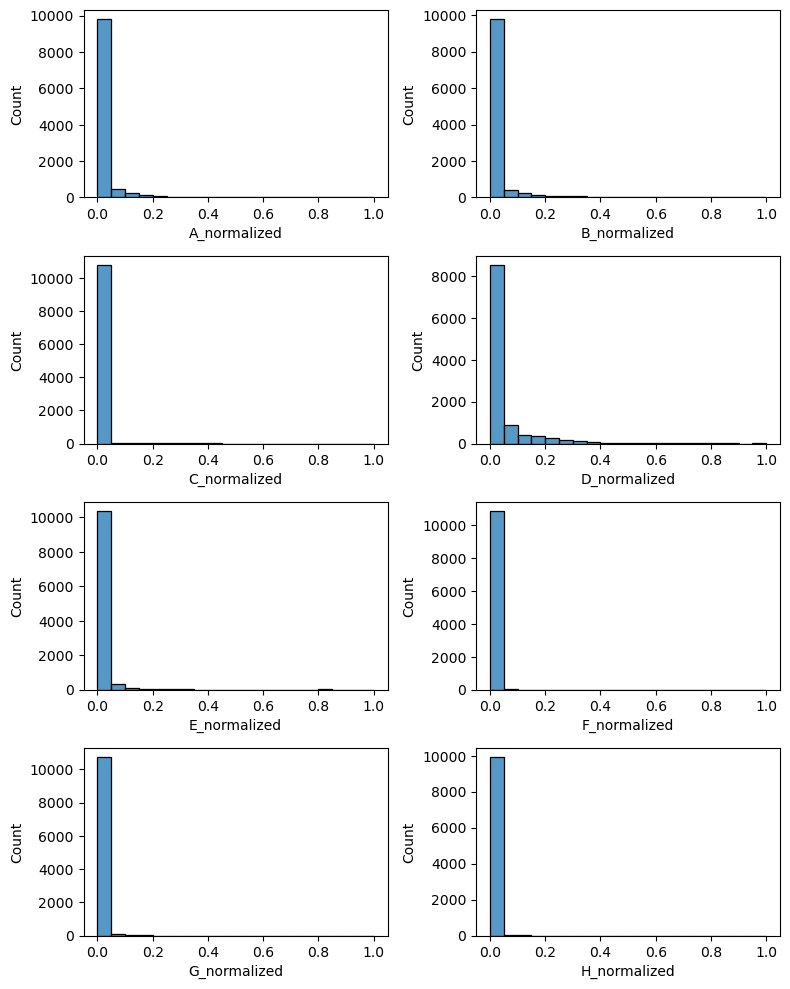

In [52]:
nbins = 20
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(8,10))
sns.histplot(df['A_normalized'], bins=nbins, ax=axs[0][0])
sns.histplot(df['B_normalized'], bins=nbins, ax=axs[0][1])
sns.histplot(df['C_normalized'], bins=nbins, ax=axs[1][0])
sns.histplot(df['D_normalized'], bins=nbins, ax=axs[1][1])
sns.histplot(df['E_normalized'], bins=nbins, ax=axs[2][0])
sns.histplot(df['F_normalized'], bins=nbins, ax=axs[2][1])
sns.histplot(df['G_normalized'], bins=nbins, ax=axs[3][0])
sns.histplot(df['H_normalized'], bins=nbins, ax=axs[3][1])
plt.tight_layout()
plt.show()

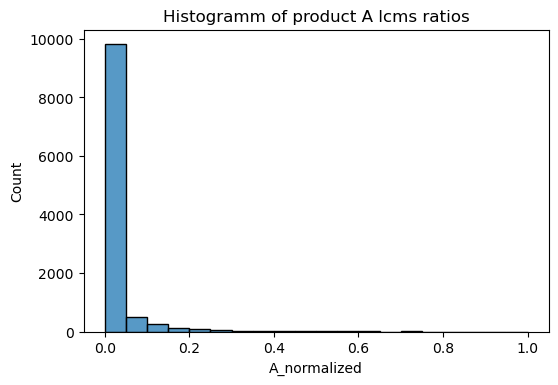

In [53]:
plt.figure()
sns.histplot(df['A_normalized'], bins=20)
plt.title('Histogramm of product A lcms ratios')
plt.show()

<Figure size 600x400 with 0 Axes>

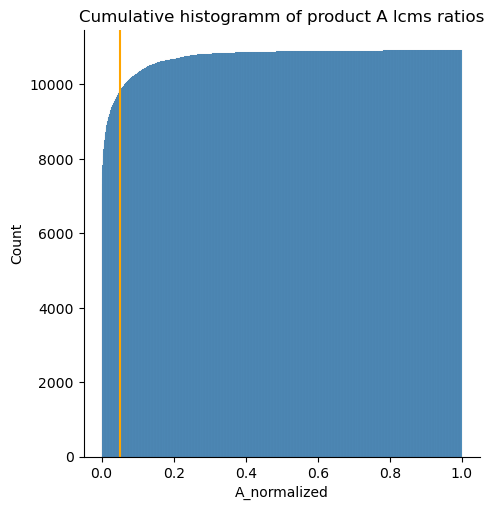

In [54]:
# let's see the same as a cumulative histogramm
plt.figure()
sns.displot(df['A_normalized'], cumulative=True)
plt.title('Cumulative histogramm of product A lcms ratios')
plt.axvline(x=0.05, color='orange')
plt.show()

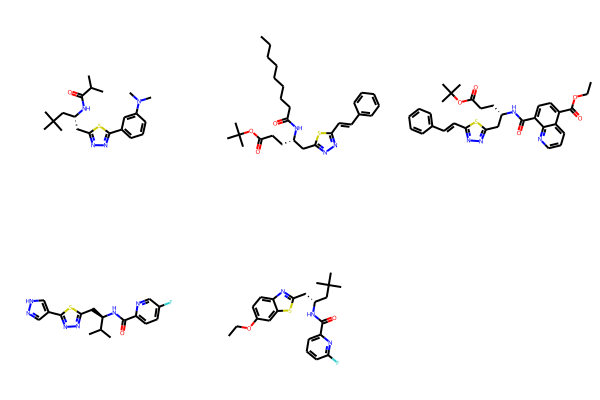

In [55]:
# What products have the highest "yields"?
from rdkit.Chem.AllChem import Compute2DCoords, EmbedMolecule, GenerateDepictionMatching3DStructure
products = []
for vl_id in df.sort_values('A_normalized', ascending=False).head(5)['vl_id']:
    products.append(db.get_vl_member(vl_id))
[Compute2DCoords(p) for p in products]
Draw.MolsToGridImage(products)

In [56]:
# let's check the highest "yielding" reaction
df.sort_values('A_normalized', ascending=False).head(1)

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,B_normalized,C_normalized,D_normalized,E_normalized,F_normalized,G_normalized,H_normalized,initiator_type,monomer_type,terminator_type
id,,,,,,,,,,,,,,,,,,,,,
23418,9,6,O6,JG282,2021-11-01 23:00:00,I30,M24,T34,Al007,Mon022,...,0.076391,0.015346,0.00056,0.024985,0.002228,0.009124,0.001514,KAT_al,Mon_sub_3,TerTH


### Building Block statistics <a id=4></a>

Let's look into details: __For each initator, how many reactions have worked above 5%?__

In [57]:
def calc_success_rate(df, column, threshold, sort_results=True):
    """
    Take a dataframe df, where for one column of interest, for each unique identifier in that column, the frequency
    of successful reactions (as indicated by the threshold) is calculated.
    :param df: pandas.DataFrame
    :param column: Column by which to group, e.g. monomer or monomer_type
    :param threshold: float, threshold for success
    :return: pandas.DataFrame
    """
    success_rates = []
    for i in df[column].unique():
        df_i = df.loc[df[column] == i]
        n_all = len(df_i)
        n_success = len(df_i.loc[df['A_normalized'] >= threshold])
        success_rates.append([i, n_success, n_all, n_success/n_all])
    if sort_results is True:
        success_rates = sorted(success_rates, key=lambda x: int(x[0][1:]))
    return pd.DataFrame(success_rates, columns=[column, 'n_success', 'n_all', 'success_rate'])

In [58]:
# we calculate success rates for all initiators
success_rates_by_initiator = calc_success_rate(df, 'initiator', 0.05)
for _, i in success_rates_by_initiator.iterrows():
    print(f'Success rate for {i[0]}: {i[3]:.1%} ({i[1]}/{i[2]})')

Success rate for I3: 16.2% (36/222)
Success rate for I4: 6.1% (16/263)
Success rate for I5: 12.7% (35/276)
Success rate for I6: 20.7% (45/217)
Success rate for I7: 18.5% (42/227)
Success rate for I8: 14.7% (30/204)
Success rate for I10: 17.3% (32/185)
Success rate for I12: 5.7% (16/283)
Success rate for I14: 7.0% (18/258)
Success rate for I15: 10.3% (25/243)
Success rate for I17: 8.5% (20/234)
Success rate for I18: 0.0% (0/268)
Success rate for I19: 7.7% (16/209)
Success rate for I20: 4.5% (9/198)
Success rate for I21: 8.1% (15/186)
Success rate for I22: 12.2% (27/221)
Success rate for I23: 6.1% (11/181)
Success rate for I24: 13.9% (29/208)
Success rate for I25: 12.1% (28/232)
Success rate for I26: 14.9% (33/222)
Success rate for I28: 1.0% (3/288)
Success rate for I29: 9.1% (24/265)
Success rate for I30: 9.7% (25/259)
Success rate for I31: 19.3% (38/197)
Success rate for I32: 7.2% (19/265)
Success rate for I33: 9.1% (23/253)
Success rate for I36: 3.2% (5/154)
Success rate for I37: 14.0

In [59]:
# let's do the same for monomers
success_rates_by_monomer = calc_success_rate(df, 'monomer', 0.05)
for _, i in success_rates_by_monomer.iterrows():
    print(f'Success rate for {i[0]}: {i[3]:.1%} ({i[1]}/{i[2]})')

Success rate for M1: 0.0% (0/320)
Success rate for M2: 0.3% (1/320)
Success rate for M3: 0.3% (1/286)
Success rate for M4: 13.8% (35/253)
Success rate for M6: 9.1% (29/320)
Success rate for M7: 0.3% (1/320)
Success rate for M8: 0.0% (0/137)
Success rate for M9: 1.4% (2/141)
Success rate for M10: 40.3% (129/320)
Success rate for M12: 0.0% (0/106)
Success rate for M14: 0.0% (0/251)
Success rate for M15: 0.0% (0/268)
Success rate for M17: 0.0% (0/320)
Success rate for M18: 0.0% (0/271)
Success rate for M19: 0.0% (0/53)
Success rate for M20: 54.4% (174/320)
Success rate for M22: 0.0% (0/261)
Success rate for M23: 0.0% (0/139)
Success rate for M24: 45.0% (27/60)
Success rate for M26: 0.0% (0/269)
Success rate for M28: 0.0% (0/320)
Success rate for M29: 11.6% (29/250)
Success rate for M31: 5.9% (5/85)
Success rate for M32: 41.1% (83/202)
Success rate for M33: 37.4% (37/99)
Success rate for M34: 64.0% (137/214)
Success rate for M37: 0.0% (0/148)
Success rate for M38: 0.0% (0/132)
Success rate

In [60]:
# and the same for terminators
success_rates_by_terminator = calc_success_rate(df, 'terminator', 0.05)
for _, i in success_rates_by_terminator.iterrows():
    print(f'Success rate for {i[0]}: {i[3]:.1%} ({i[1]}/{i[2]})')

Success rate for T1: 14.0% (95/679)
Success rate for T2: 4.4% (6/137)
Success rate for T3: 11.6% (32/275)
Success rate for T5: 0.0% (0/155)
Success rate for T7: 11.2% (31/276)
Success rate for T8: 0.4% (3/694)
Success rate for T11: 0.0% (0/148)
Success rate for T12: 4.7% (7/148)
Success rate for T13: 7.3% (21/287)
Success rate for T17: 12.0% (80/669)
Success rate for T18: 0.3% (2/712)
Success rate for T19: 10.8% (13/120)
Success rate for T20: 19.1% (50/262)
Success rate for T21: 1.4% (4/279)
Success rate for T22: 15.3% (102/667)
Success rate for T23: 6.4% (8/125)
Success rate for T25: 8.7% (61/704)
Success rate for T26: 11.5% (14/122)
Success rate for T27: 20.0% (55/275)
Success rate for T28: 18.6% (52/280)
Success rate for T29: 7.3% (10/137)
Success rate for T30: 11.1% (76/683)
Success rate for T31: 27.8% (79/284)
Success rate for T32: 11.2% (33/294)
Success rate for T33: 11.6% (14/121)
Success rate for T34: 14.9% (98/656)
Success rate for T36: 11.6% (77/664)
Success rate for T38: 0.8

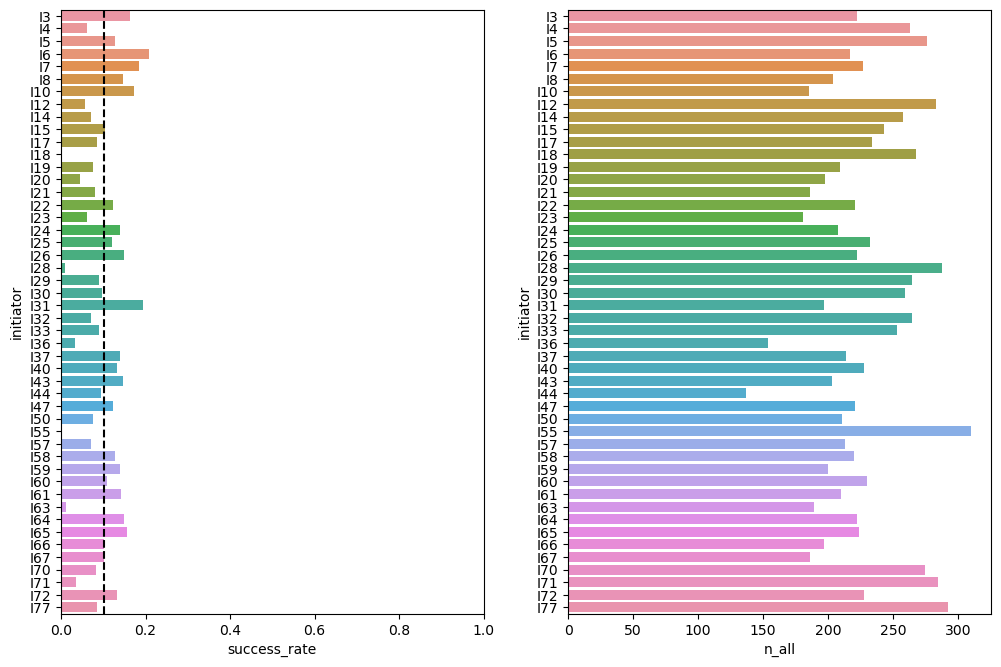

In [61]:
# show how many reactions are successful for each initiator
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
axs[0].set_xlabel('Ratio of reactions with normalized lcms ratio >5%')
axs[0].set_xlim(0,1)
axs[0].axvline(success_rates_by_initiator['success_rate'].mean(), ls='--', c='black')  # draw a mean line
sns.barplot(x=success_rates_by_initiator['success_rate'], y=success_rates_by_initiator['initiator'], ax=axs[0])

axs[1].set_xlabel('Number of reactions in dataset')
sns.barplot(x=success_rates_by_initiator['n_all'], y=success_rates_by_initiator['initiator'], ax=axs[1])
plt.show()

In [62]:
df_full.loc[df_full['initiator'] == 'I44', 'valid'].value_counts()

I/M transfer error; Dilution survey low volume                                                                                                                                                 55
I/M transfer error; Dilution transfer error; Dilution survey low volume                                                                                                                        22
too many peaks for product A (2)                                                                                                                                                                6
I/M transfer error; Dilution survey low volume; too many peaks for IS (2); WARNING: IS response differs >50% from mean                                                                          3
I/M transfer error                                                                                                                                                                              3
I/M transfer error; Dilution s

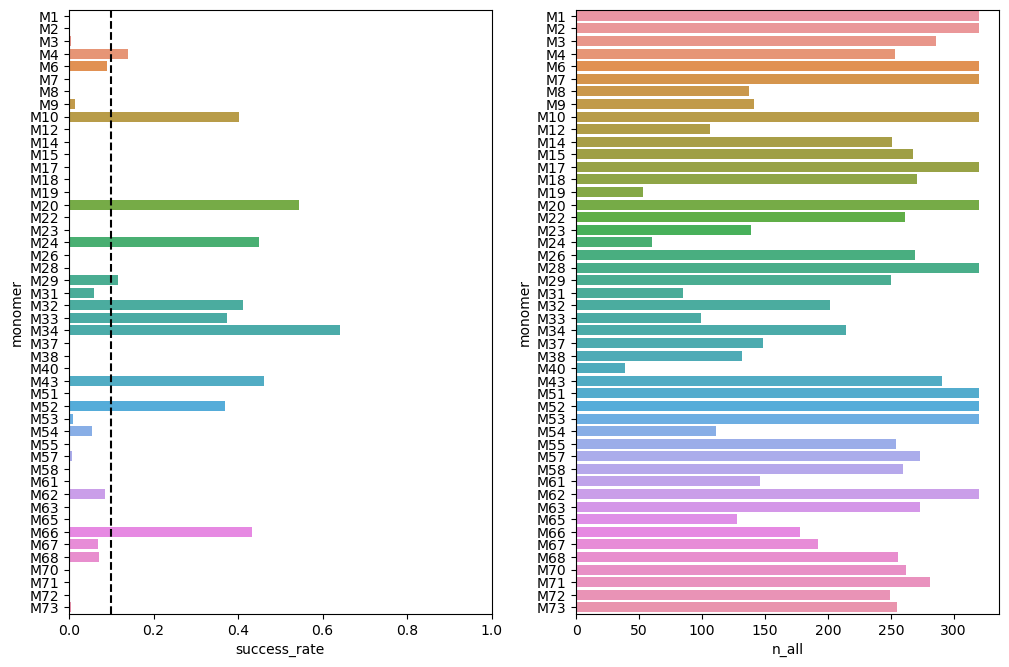

In [63]:
# show how many reactions are successful for each monomer
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
axs[0].set_xlabel('Ratio of reactions with normalized lcms ratio >5%')
axs[0].set_xlim(0,1)
axs[0].axvline(success_rates_by_monomer['success_rate'].mean(), ls='--', c='black')
sns.barplot(x=success_rates_by_monomer['success_rate'], y=success_rates_by_monomer['monomer'], ax=axs[0])

axs[1].set_xlabel('Number of reactions in dataset')
sns.barplot(x=success_rates_by_monomer['n_all'], y=success_rates_by_monomer['monomer'], ax=axs[1])
plt.show()

In [64]:
df.loc[df['monomer'] == 'M34'].sort_values('A_normalized', ascending=False).head(5)

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,B_normalized,C_normalized,D_normalized,E_normalized,F_normalized,G_normalized,H_normalized,initiator_type,monomer_type,terminator_type
id,,,,,,,,,,,,,,,,,,,,,
24807,10,5,E15,JG287,2021-11-15 23:00:00,I43,M34,T26,BiPh006,Mon076,...,0.121740,0.011548,0.002287,0.011654,0.001510,0.007205,0.000213,KAT_arom,Mon_sub_3,TerTH
24967,10,5,M15,JG287,2021-11-15 23:00:00,I8,M34,T26,2-Pyr010,Mon076,...,0.191832,0.002302,0.000537,0.008230,0.002841,0.006828,0.000000,KAT_hetarom,Mon_sub_3,TerTH
24810,10,5,E18,JG287,2021-11-15 23:00:00,I43,M34,T33,BiPh006,Mon076,...,0.185696,0.002703,0.002055,0.005750,0.001176,0.003439,0.000000,KAT_arom,Mon_sub_3,TerTH
24809,10,5,E17,JG287,2021-11-15 23:00:00,I43,M34,T19,BiPh006,Mon076,...,0.322243,0.001641,0.001238,0.005273,0.000848,0.003475,0.000000,KAT_arom,Mon_sub_3,TerTH
14894,6,5,H19,JG262,2021-08-30 22:00:00,I6,M34,T3,2-Pyr008,Mon076,...,0.000000,0.000000,0.000086,0.000000,0.006840,0.022439,0.000240,KAT_hetarom,Mon_sub_3,TerABT


In [65]:
df.loc[df['monomer'] == 'M18'].sort_values('A_normalized', ascending=False).head(15)

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,B_normalized,C_normalized,D_normalized,E_normalized,F_normalized,G_normalized,H_normalized,initiator_type,monomer_type,terminator_type
id,,,,,,,,,,,,,,,,,,,,,
16169,7,1,H14,JG264,2021-09-15 22:00:00,I70,M18,T39,Ph026,Mon015,...,0.000000,0.000000,0.053516,0.007385,0.000000,0.000000,0.000000,KAT_arom,Mon_sub_3,TerTH
12190,4,1,A15,JG246,2021-07-14 22:00:00,I15,M18,T31,4-Pym001,Mon015,...,0.000000,0.000000,0.008473,0.131469,0.000000,0.000000,0.015899,KAT_hetarom,Mon_sub_3,TerTH
12294,4,1,F19,JG246,2021-07-14 22:00:00,I18,M18,T3,4-Pyrazole002,Mon015,...,0.000064,0.001951,0.000000,0.066148,0.000036,0.000367,0.000000,KAT_hetarom,Mon_sub_3,TerABT
12490,4,1,P15,JG246,2021-07-14 22:00:00,I33,M18,T31,Al038,Mon015,...,0.000000,0.000000,0.229176,0.131850,0.000000,0.000000,0.000000,KAT_al,Mon_sub_3,TerTH
16189,7,1,I14,JG264,2021-09-15 22:00:00,I12,M18,T39,3-Pyr003,Mon015,...,0.000000,0.000000,0.058656,0.004333,0.000000,0.000000,0.000000,KAT_hetarom,Mon_sub_3,TerTH
16037,7,1,A22,JG264,2021-09-15 22:00:00,I15,M18,T22,4-Pym001,Mon015,...,0.000000,0.000000,0.001776,0.010476,0.000000,0.000000,0.000049,KAT_hetarom,Mon_sub_3,TerTH
16233,7,1,K18,JG264,2021-09-15 22:00:00,I5,M18,T36,2-Pyr007,Mon015,...,0.000000,0.000000,0.022654,0.002686,0.000000,0.000000,0.000331,KAT_hetarom,Mon_sub_3,TerTH
12436,4,1,M21,JG246,2021-07-14 22:00:00,I71,M18,T13,Ph027,Mon015,...,0.000000,0.000000,0.000231,0.000708,0.000000,0.000000,0.000000,KAT_arom,Mon_sub_3,TerABT
16031,7,1,A16,JG264,2021-09-15 22:00:00,I15,M18,T34,4-Pym001,Mon015,...,0.000000,0.001980,0.005496,0.013926,0.000000,0.000000,0.000000,KAT_hetarom,Mon_sub_3,TerTH


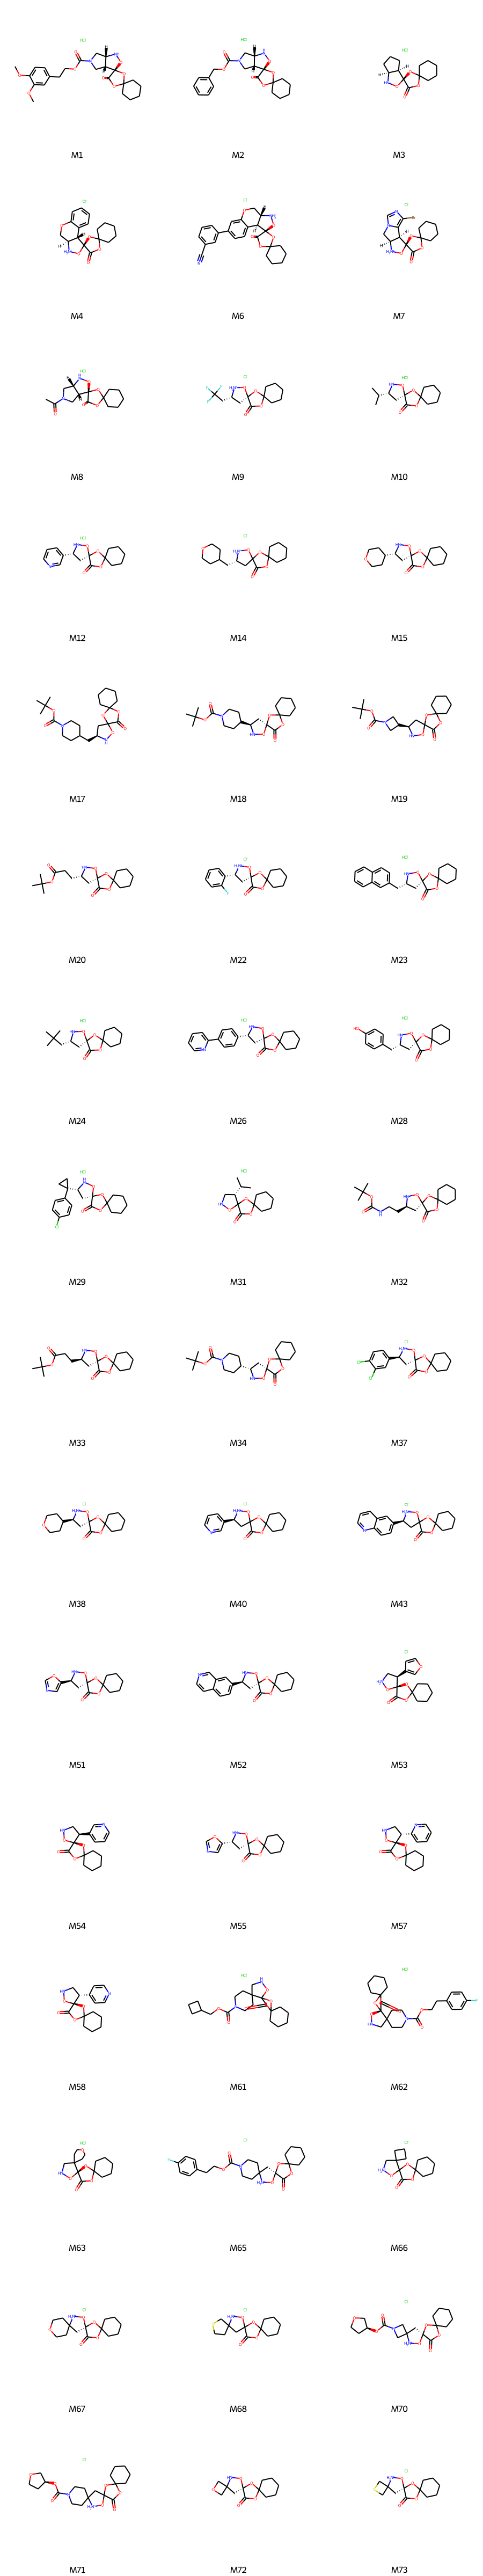

In [66]:
monomer_mols = []
for x in success_rates_by_monomer['monomer']:
    monomer_mols.append(db.get_mol(x))
Draw.MolsToGridImage(monomer_mols, subImgSize=(300, 300), legends=success_rates_by_monomer['monomer'].tolist())

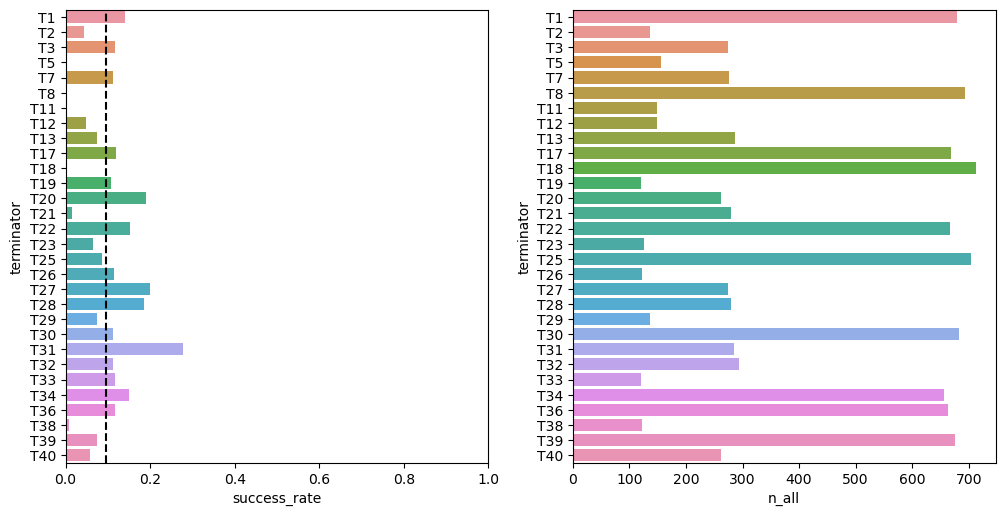

In [67]:
# show how many reactions are successful for each terminator
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
axs[0].set_xlabel('Ratio of reactions with normalized lcms ratio >5%')
axs[0].set_xlim(0,1)
axs[0].axvline(success_rates_by_terminator['success_rate'].mean(), ls='--', c='black')
sns.barplot(x=success_rates_by_terminator['success_rate'], y=success_rates_by_terminator['terminator'], ax=axs[0])

axs[1].set_xlabel('Number of reactions in dataset')
sns.barplot(x=success_rates_by_terminator['n_all'], y=success_rates_by_terminator['terminator'], ax=axs[1])
plt.show()

### Trends within builing block classes <a id=5></a>
Let's look at how well different types of initiators, monomers, terminators react

In [68]:
# let's check Initiators
success_rates_by_initiator_type = calc_success_rate(df, 'initiator_type', 0.05, sort_results=False)
for _, i in success_rates_by_initiator_type.iterrows():
    print(f'Success rate for {i[0]}: {i[3]:.1%} ({i[1]}/{i[2]})')

Success rate for KAT_arom: 10.2% (404/3972)
Success rate for KAT_al: 9.7% (228/2349)
Success rate for KAT_hetarom: 10.0% (457/4592)


In [69]:
# let's check Monomers
success_rates_by_monomer_type = calc_success_rate(df, 'monomer_type', 0.05, sort_results=False)
for _, i in success_rates_by_monomer_type.iterrows():
    print(f'Success rate for {i[0]}: {i[1]/i[2]:.1%} ({i[1]}/{i[2]})')

Success rate for Mon_fused: 3.4% (67/1956)
Success rate for Mon_sub_3: 16.2% (870/5368)
Success rate for Mon_sub_2: 1.5% (16/1049)
Success rate for Mon_spiro_2: 11.3% (104/917)
Success rate for Mon_spiro_3: 2.0% (32/1623)


In [70]:
# let's check Terminators
success_rates_by_terminator_type = calc_success_rate(df, 'terminator_type', 0.05, sort_results=False)
for _, i in success_rates_by_terminator_type.iterrows():
    print(f'Success rate for {i[0]}: {i[1]/i[2]:.1%} ({i[1]}/{i[2]})')

Success rate for TerTH: 12.1% (812/6733)
Success rate for TerABT: 6.6% (277/4180)


### Trends controlled for monomer behavior <a id=6></a>
Here we want to look at initiator and terminator success rates only for those monomers that typically work.
For simplicity, we accept only monomers that are have a success ratio of >= 10%

In [71]:
successful_monomers = success_rates_by_monomer.loc[success_rates_by_monomer['success_rate'] >=0.10, 'monomer']
successful_monomers

3      M4
8     M10
15    M20
18    M24
21    M29
23    M32
24    M33
25    M34
29    M43
31    M52
41    M66
Name: monomer, dtype: object

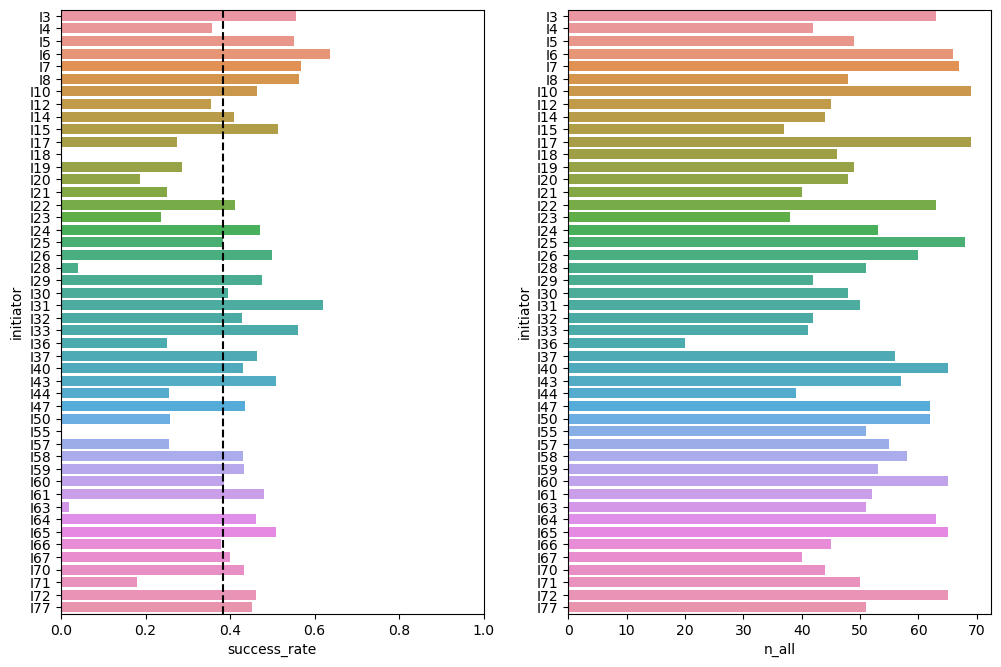

In [72]:
success_rates_by_initiator_for_successful_monomers = calc_success_rate(df.loc[df['monomer'].isin(successful_monomers)], 'initiator', 0.05)

# show how many reactions are successful for each initiator, only considering monomers that react well
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
axs[0].set_xlabel('Ratio of reactions with normalized lcms ratio >5%')
axs[0].set_xlim(0,1)
axs[0].axvline(success_rates_by_initiator_for_successful_monomers['success_rate'].mean(), ls='--', c='black')
sns.barplot(x=success_rates_by_initiator_for_successful_monomers['success_rate'], y=success_rates_by_initiator_for_successful_monomers['initiator'], ax=axs[0])

axs[1].set_xlabel('Number of reactions in dataset')
sns.barplot(x=success_rates_by_initiator_for_successful_monomers['n_all'], y=success_rates_by_initiator_for_successful_monomers['initiator'], ax=axs[1])
plt.show()

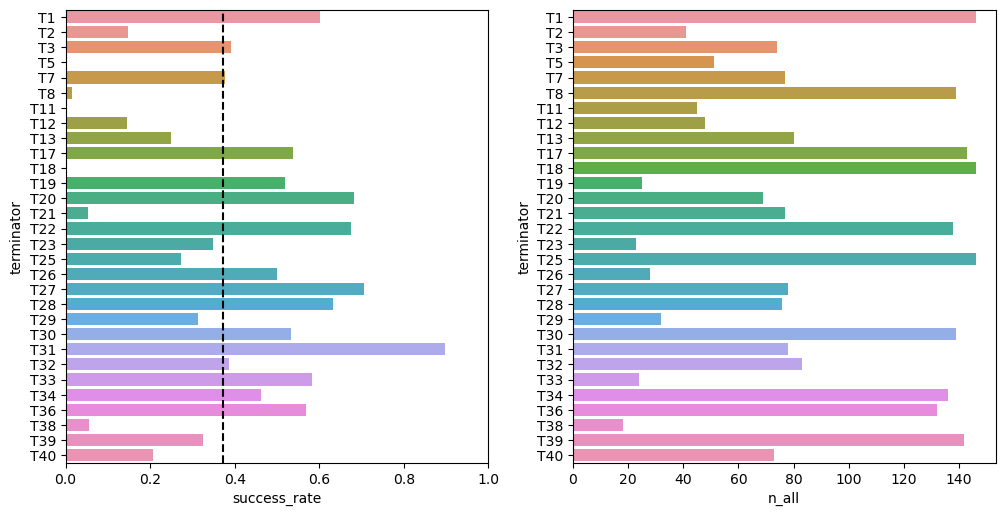

In [73]:
success_rates_by_terminator_for_successful_monomers = calc_success_rate(df.loc[df['monomer'].isin(successful_monomers)], 
                                                                        'terminator', 
                                                                        0.05,
                                                                       )

# show how many reactions are successful for each terminator, only considering monomers that react well
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
axs[0].set_xlabel('Ratio of reactions with normalized lcms ratio >5%')
axs[0].set_xlim(0,1)
axs[0].axvline(success_rates_by_terminator_for_successful_monomers['success_rate'].mean(), ls='--', c='black')
sns.barplot(x=success_rates_by_terminator_for_successful_monomers['success_rate'], y=success_rates_by_terminator_for_successful_monomers['terminator'], ax=axs[0])

axs[1].set_xlabel('Number of reactions in dataset')
sns.barplot(x=success_rates_by_terminator_for_successful_monomers['n_all'], y=success_rates_by_terminator_for_successful_monomers['terminator'], ax=axs[1])
plt.show()

What remains to do?

- Investigate what happens to the monomers where no product A is formed: Do they stall at F/G? Do they not react and we get a lot of D or H instead?

In [74]:
db.show_image('I63')